In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
sys.path.append('../../utils/')
from fig12code import *

In [2]:
rename_cols = {'Unnamed: 0': 'lat', 
               'moussavi_pope': 'RTE_Sentinel2_red', 
               'spergel_kingslake': 'RTE_Landsat8_red_pan',
               'datta': 'watta',
               'pond': 'lake_id'
              }
dfm = pd.read_csv('raw/fricker_allCompiledDepthData.csv').rename(columns=rename_cols)

dfm['surrf_2024'] = np.nan # initialize column for surrf
dfm['lon'] = np.nan # initialize column for surrf
dfm['dist_along_track_m'] = np.nan # initialize column for surrf

ref_idx = 1.336
conf_threshold = 0.3

dfsorts = []

for ilake in np.arange(1,5):
    
    selector = dfm.lake_id == ilake
    dfi = dfm[selector].copy()
    lk = dictobj(read_melt_lake_h5('lake_amery_fricker_%i.h5' % ilake))
    hsurf = lk.surface_elevation
    surf = np.ones_like(dfi.manual)*hsurf
    surf[dfi.manual==0] = np.nan
    df = lk.photon_data
    df.loc[df.h < hsurf, 'h'] = hsurf - (hsurf - df.loc[df.h < hsurf, 'h']) / ref_idx
    dfd = lk.depth_data.sort_values(by='lat')
    man_bed = hsurf - dfi.manual
    man_bed[dfi.manual == 0] = np.nan
    fit_bed = dfd.h_fit_bed.copy()
    fit_bed[fit_bed > hsurf] = np.nan
    fit_bed[(dfd.conf < conf_threshold)] = np.nan
    
    depth = dfd.depth.copy()
    depth[(dfd.conf < conf_threshold)] = np.nan
    depth_interp = np.interp(dfi.lat, dfd.lat, depth, left=np.nan, right=np.nan)
    dfm.loc[selector, 'surrf_2024'] = depth_interp

    # get the lat/lon/xatc
    df['x10'] = np.round(df.xatc, -1)
    gt = df.groupby('x10')[['xatc', 'lon', 'lat']].median().sort_values(by='lat').reset_index(drop=True)
    dfm.loc[selector, 'lon'] = np.interp(dfm[selector].lat, gt.lat, gt.lon)
    dfm.loc[selector, 'dist_along_track_m'] = np.interp(dfm[selector].lat, gt.lat, gt.xatc)

    dfsort = dfm[dfm.lake_id == ilake].sort_values(by='dist_along_track_m').copy()
    dist = np.arange(np.ceil(dfsort.dist_along_track_m.min()), dfsort.dist_along_track_m.max(), 5)
    df_res = pd.DataFrame({'lake_id': ilake, 'dist_along_track_m': dist})
    for c in ['lon', 'lat', 'manual', 'surrf_2024', 'RTE_Sentinel2_red', 'RTE_Landsat8_red_pan', 'watta']: 
        df_res[c] = np.interp(df_res.dist_along_track_m, dfsort.dist_along_track_m, dfsort[c])

    dfsorts.append(df_res)

# df_fricker = dfm[['lake_id', 'dist_along_track_m', 'lon', 'lat', 'manual', 'surrf_2024', 'RTE_Sentinel2_red', 'RTE_Landsat8_red_pan', 'watta']].copy()

df_fricker = pd.concat(dfsorts).reset_index(drop=True)
to_correct = ['manual', 'RTE_Sentinel2_red', 'RTE_Landsat8_red_pan', 'watta']
df_fricker.loc[:,to_correct] = df_fricker.loc[:,to_correct] / ref_idx
display(df_fricker)

df_fricker.to_csv('data_fricker_2021.csv', index=False)

,lake_id,dist_along_track_m,lon,lat,manual,surrf_2024,RTE_Sentinel2_red,RTE_Landsat8_red_pan,watta
0,1,242.0,67.259597,-72.989015,0.0,0.0,0.0,0.0,NaN
1,1,247.0,67.259576,-72.989060,0.0,0.0,0.0,0.0,NaN
2,1,252.0,67.259554,-72.989104,0.0,0.0,0.0,0.0,NaN
3,1,257.0,67.259533,-72.989149,0.0,0.0,0.0,0.0,NaN
4,1,262.0,67.259512,-72.989193,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...
1037,4,1358.0,67.856341,-71.647915,0.0,0.0,0.0,0.0,NaN
1038,4,1363.0,67.856323,-71.647959,0.0,0.0,0.0,0.0,NaN
1039,4,1368.0,67.856305,-71.648004,0.0,0.0,0.0,0.0,NaN
1040,4,1373.0,67.856287,-71.648048,0.0,0.0,0.0,0.0,NaN


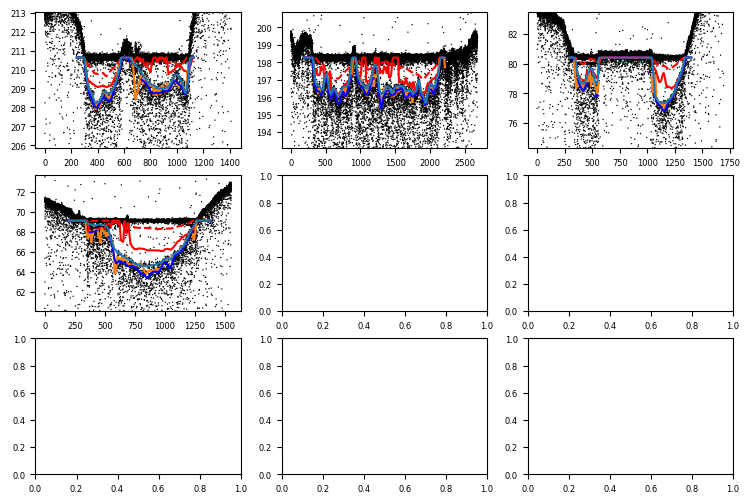

In [3]:
plt.rcParams.update({'font.size': 6})
fig, axs = plt.subplots(figsize=[9,6], nrows=3, ncols=3)
axs = axs.flatten()
for ilake in np.arange(1,5):
    ax = axs[ilake-1]
    dfinterp = df_fricker[df_fricker.lake_id == ilake]
    lk = dictobj(read_melt_lake_h5('lake_amery_fricker_%i.h5' % ilake))
    hsurf = lk.surface_elevation
    df = lk.photon_data
    df.loc[df.h < hsurf, 'h'] = hsurf - (hsurf - df.loc[df.h < hsurf, 'h']) / ref_idx
    ax.scatter(df.xatc, df.h, s=1, color='k', edgecolors='none')
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.manual, zorder=10)
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.RTE_Sentinel2_red, 'r-')
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.RTE_Landsat8_red_pan, 'r--')
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.watta)
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.surrf_2024, 'b-')
    ax.set_ylim((hsurf - 2*dfinterp.manual.max(), hsurf + dfinterp.manual.max()))
plt.close(fig)
display(fig)

# melling 2024 correct data
I have attached the data you should be using, the data I sent you previously was old and does not reflect what is in Melling et al. (2024). For context, the columns are: DIST_green                                                        -> the distance along the transect for the green band RTE depths Green_z_lit                                                       -> the green band RTE depth value when using the literature calculations for each parameter YOU MUST REVERSE THESE VALUES FOR LAKES 1, 3 AND 4 (pilot error in sampling) Z_green                                                               -> our green band RTE depth value when our calculations are used for each parameter DIST_green_uncert                                       -> the distance along the transect for the green band RTE uncertainty Z_green_min_stdev_mean                        -> the minimum uncertainty variation on our green band RTE depth value (calculated with our parameter calculations) add this to Z_green for the green band uncertainty minimum depths Z_green_max_stdev_mean                       -> the maximum uncertainty variation on our green band RTE depth value (calculated with our parameter calculations) add this to Z_green for the green band uncertainty maximum depths DIST_red                                                             -> the distance along the transect for the red band RTE depths Red_z_lit                                                            -> the red band RTE depth value when using the literature calculations for each parameter YOU MUST REVERSE THESE VALUES FOR LAKES 1, 3 AND 4 (pilot error in sampling) Z_red                                                                    -> our red band RTE depth value when our calculations are used for each parameter DIST_red_uncert                                            -> the distance along the transect for the red band RTE uncertainty Z_red_min_stdev_mean                             -> the minimum uncertainty variation on our red band RTE depth value (calculated with our parameter calculations) add this to Z_red for the red band uncertainty minimum depths Z_red_max_stdev_mean                            -> the maximum uncertainty variation on our red band RTE depth value (calculated with our parameter calculations) add this to Z_red for the red band uncertainty maximum depths DIST_dem                                                          -> the distance along the transect for the DEM depths DEM_zeroed                                                     -> depths of the DEMs with the vertical offset applied which brings it to the same relative height as the ICESat-2 estimates DIST_along_transect_corrected_IS2    -> the distance along the transect for the ICESat-2 depths (unsure why there is ‘corrected’ in the name here as I don’t remember applying a correction to this data) Manual_depths_IS2                                      -> the depths from ICESat-2 STD_high                                                            -> the maximum uncertainty variation on the ICESat-2 depths add this to Manual_depths_IS2 for the ICESat-2 maximum depths STD_low                                                             -> the minimum uncertainty variation on the ICESat-2 depths add this to Manual_depths_IS2 for the ICESat-2 minimum depths You can ignore any other columns as these are just me faffing about with data. Again, please ignore the previous email I sent you this morning, this is incorrect.

,lake_id,dist_along_track_m,lon,lat,manual,STD_high,STD_low,Z_green,Green_z_lit,Z_red,Red_z_lit,DEM_zeroed,surrf_2024
0,1,1306.5,-49.138228,67.080167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1,1301.5,-49.138216,67.080212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,1,1296.5,-49.138203,67.080256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,1,1291.5,-49.138190,67.080301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,1,1286.5,-49.138177,67.080345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,5,2049.5,-48.290592,67.536716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1516,5,2054.5,-48.290606,67.536761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1517,5,2059.5,-48.290619,67.536805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1518,5,2064.5,-48.290633,67.536850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


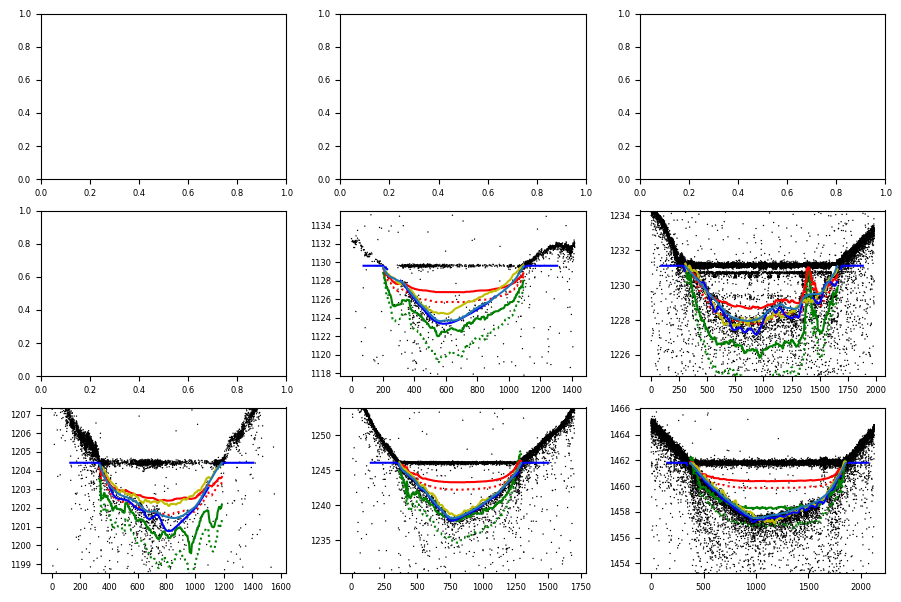

In [4]:
plt.rcParams.update({'font.size': 6})
fig, axs = plt.subplots(figsize=[9,6], nrows=3, ncols=3)
axs = axs.flatten()

wdw_dem_m = 15
dfs_melling = []
for ilake in np.arange(1,6):

    # add the surrf depth and along-track distance
    lk = dictobj(read_melt_lake_h5('lake_greenland_melling_%i.h5' % ilake))
    df = lk.photon_data
    dfd = lk.depth_data.sort_values(by='lat').reset_index(drop=True)
    hsurf = lk.surface_elevation
    df.loc[df.h < hsurf, 'h'] = hsurf - (hsurf - df.loc[df.h < hsurf, 'h']) / ref_idx
    
    # get the lat/lon/xatc
    df['x10'] = np.round(df.xatc, -1)
    gt = df.groupby('x10')[['xatc', 'lon', 'lat']].median().sort_values(by='lat').reset_index(drop=True)
    
    dfindi = pd.read_csv('raw/melling_L%i_alldata.csv' % ilake)
    dfis2 = pd.read_csv('raw/melling_is2_lake%i.csv' % ilake)
    
    dfinterp = pd.DataFrame({'lake_id': ilake, 'dist_along_track_m': dfd.xatc, 'lon': dfd.lon, 'lat': dfd.lat})
    cols = {
        'is2': ['DIST_along_transect_corrected_IS2', 'Manual_depths_IS2', 'STD_high', 'STD_low'],
        'green': ['DIST_green', 'Z_green', 'Green_z_lit'],
        'red': ['DIST_red', 'Z_red', 'Red_z_lit'],
        'dem': ['DIST_dem', 'DEM_zeroed'] 
    }
    fit = np.poly1d(np.polyfit(dfis2['Distance along the transect (m)'], dfis2.Latitude, 1)) 
    for key in cols.keys():
        for val in cols[key][1:]:
            # dist_orig = dfindi[cols[key][0]]
            # lat = np.interp(, , left=np.nan, right=np.nan)
            lat = fit(dfindi[cols[key][0]])
            dfinterp[val] = np.interp(dfinterp.lat, lat, dfindi[val], left=np.nan, right=np.nan)
    # dfinterp['Z_corrected_dem'] = dfinterp.Z_corrected_dem.rolling(window=10, center=True, min_periods=1, win_type='gaussian').mean(std=1)
    
    surf = np.ones_like(dfinterp.dist_along_track_m)*hsurf
    surf[dfinterp.Manual_depths_IS2==0] = np.nan
    man_bed = hsurf - dfinterp.Manual_depths_IS2
    man_bed[dfinterp.Manual_depths_IS2==0] = np.nan
    fit_bed = dfd.h_fit_bed.copy()
    fit_bed[fit_bed > hsurf] = np.nan
    fit_bed[(dfd.conf < conf_threshold)] = np.nan
    depth = dfd.depth.copy()
    depth[(dfd.conf < conf_threshold)] = np.nan
    depth_interp = np.interp(dfinterp.lat, dfd.lat, depth, left=np.nan, right=np.nan)
    dfinterp['surrf_2024'] = depth_interp

    dfs_melling.append(dfinterp)

    ax = axs[ilake+3]
    ax.scatter(df.xatc, df.h, s=1, color='k', edgecolors='none')
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.Manual_depths_IS2, zorder=10)
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.Z_green, 'g-')
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.Green_z_lit, 'g:')
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.Z_red, 'r-')
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.Red_z_lit, 'r:')
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.DEM_zeroed, 'y-')
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.surrf_2024, 'b-')
    ax.set_ylim((hsurf - 2*dfinterp.Manual_depths_IS2.max(), hsurf + dfinterp.Manual_depths_IS2.max()))

fig.tight_layout()
    
df_melling = pd.concat(dfs_melling).reset_index(drop=True).rename(columns={'Manual_depths_IS2': 'manual'})
# df_melling = df_melling[list(df_melling.keys())[:4] + ['surrf_2024', 'Manual_depths_IS2', 'Z_green', 'Z_red', 'Z_corrected_dem']].rename(columns={'Manual_depths_IS2': 'manual'})
display(df_melling)
plt.close(fig)
display(fig)

df_melling.to_csv('data_melling_2024.csv', index=False)

# melling 2024 old data
Hi Philipp, Please disregard my previous email and data. I have attached the data you should be using, the data I sent you previously was old and does not reflect what is in Melling et al. (2024). You can ignore any other columns as these are just me faffing about with data. Again, please ignore the previous email I sent you this morning, this is incorrect. Please let me know if anything doesn’t make sense or you want to have a quick videocall etc, etc,(2024).

 


,lake_id,dist_along_track_m,lon,lat,surrf_2024,manual,Z_green,Z_red,Z_corrected_dem
0,1,1306.5,-49.138228,67.080167,0.0,NaN,NaN,NaN,NaN
1,1,1301.5,-49.138216,67.080212,0.0,NaN,NaN,NaN,NaN
2,1,1296.5,-49.138203,67.080256,0.0,NaN,NaN,NaN,NaN
3,1,1291.5,-49.138190,67.080301,0.0,NaN,NaN,NaN,NaN
4,1,1286.5,-49.138177,67.080345,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1515,5,2049.5,-48.290592,67.536716,0.0,NaN,NaN,NaN,NaN
1516,5,2054.5,-48.290606,67.536761,0.0,NaN,NaN,NaN,NaN
1517,5,2059.5,-48.290619,67.536805,0.0,NaN,NaN,NaN,NaN
1518,5,2064.5,-48.290633,67.536850,0.0,NaN,NaN,NaN,NaN


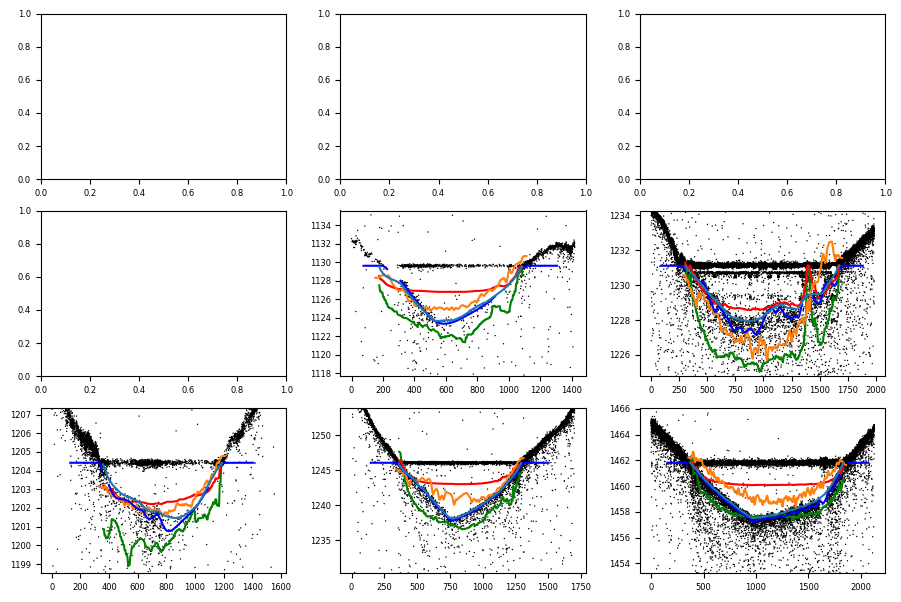

In [5]:
plt.rcParams.update({'font.size': 6})
fig, axs = plt.subplots(figsize=[9,6], nrows=3, ncols=3)
axs = axs.flatten()

wdw_dem_m = 15
dfs_melling = []
for ilake in np.arange(1,6):

    # add the surrf depth and along-track distance
    lk = dictobj(read_melt_lake_h5('lake_greenland_melling_%i.h5' % ilake))
    df = lk.photon_data
    dfd = lk.depth_data.sort_values(by='lat').reset_index(drop=True)
    hsurf = lk.surface_elevation
    df.loc[df.h < hsurf, 'h'] = hsurf - (hsurf - df.loc[df.h < hsurf, 'h']) / ref_idx
    
    # get the lat/lon/xatc
    df['x10'] = np.round(df.xatc, -1)
    gt = df.groupby('x10')[['xatc', 'lon', 'lat']].median().sort_values(by='lat').reset_index(drop=True)
    
    dfindi = pd.read_csv('raw/melling_indi_lake%i.csv' % ilake)
    dfis2 = pd.read_csv('raw/melling_is2_lake%i.csv' % ilake)
    
    dfinterp = pd.DataFrame({'lake_id': ilake, 'dist_along_track_m': dfd.xatc, 'lon': dfd.lon, 'lat': dfd.lat})
    cols = {
        'is2': ['DIST_along_transect_corrected_IS2', 'Manual_depths_IS2', 'STD_high', 'STD_low'],
        'green': ['DIST_green', 'Z_green', 'Z_green_min_Ad', 'Z_green_max_Ad'],
        'red': ['DIST_red', 'Z_red', 'Z_red_min_Ad', 'Z_red_max_Ad'],
        'dem': ['DIST_dem', 'DEM_uncorrected_z', 'Z_corrected_dem', 'DEM_first_zero'] 
    }
    fit = np.poly1d(np.polyfit(dfis2['Distance along the transect (m)'], dfis2.Latitude, 1)) 
    for key in cols.keys():
        for val in cols[key][1:]:
            # dist_orig = dfindi[cols[key][0]]
            # lat = np.interp(, , left=np.nan, right=np.nan)
            lat = fit(dfindi[cols[key][0]])
            dfinterp[val] = np.interp(dfinterp.lat, lat, dfindi[val], left=np.nan, right=np.nan)
    dfinterp['Z_corrected_dem'] = dfinterp.Z_corrected_dem.rolling(window=10, center=True, min_periods=1, win_type='gaussian').mean(std=1)
    
    surf = np.ones_like(dfinterp.dist_along_track_m)*hsurf
    surf[dfinterp.Manual_depths_IS2==0] = np.nan
    man_bed = hsurf - dfinterp.Manual_depths_IS2
    man_bed[dfinterp.Manual_depths_IS2==0] = np.nan
    fit_bed = dfd.h_fit_bed.copy()
    fit_bed[fit_bed > hsurf] = np.nan
    fit_bed[(dfd.conf < conf_threshold)] = np.nan
    depth = dfd.depth.copy()
    depth[(dfd.conf < conf_threshold)] = np.nan
    depth_interp = np.interp(dfinterp.lat, dfd.lat, depth, left=np.nan, right=np.nan)
    dfinterp['surrf_2024'] = depth_interp

    dfs_melling.append(dfinterp)

    ax = axs[ilake+3]
    ax.scatter(df.xatc, df.h, s=1, color='k', edgecolors='none')
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.Manual_depths_IS2, zorder=10)
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.Z_green, 'g-')
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.Z_red, 'r-')
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.Z_corrected_dem)
    ax.plot(dfinterp.dist_along_track_m, hsurf - dfinterp.surrf_2024, 'b-')
    ax.set_ylim((hsurf - 2*dfinterp.Manual_depths_IS2.max(), hsurf + dfinterp.Manual_depths_IS2.max()))

fig.tight_layout()
    
df_melling = pd.concat(dfs_melling).reset_index(drop=True)
df_melling = df_melling[list(df_melling.keys())[:4] + ['surrf_2024', 'Manual_depths_IS2', 'Z_green', 'Z_red', 'Z_corrected_dem']].rename(columns={'Manual_depths_IS2': 'manual'})
display(df_melling)
plt.close(fig)
display(fig)

# df_melling.to_csv('data_melling_2024.csv', index=False)